# Project 4: Ordinary Differential Equation Solving
This project introduces numerical methods to solve a physical ODE.

## Objective:
A large mass is attached to a strong spring and is allowed to oscillate. There is a drag on the system such that the mass ceases its oscillation after a while. We can model this as a second order, linear ODE

$$m\frac{d^{2}x}{dt^{2}}=-kx-c\frac{dx}{dt}$$

1. Solve the system using a self-built fourth-order Rugge-Kutta method
    1. Let $m=4~\text{kg}, c=2~\text{Ns/m}, k=16~\text{N/m}$, initial condition $x(0)=2~\text{m}$ and boundary condition $\frac{dx}{dt}|_{t=0}=30~\text{m/s}$ in the range $0<t<20~\text{s}$.

3. Determine the solution to the problem using a solver from <code>scipy.integrate</code>.

4. Now use the <code>sympy</code> package to determine the answer.

5. Compare the three methods by plotting the answer.

## Solutions:

We first import the relevant packages for this project

In [419]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sympy as sym
from sympy.plotting import plot3d

plt.style.use('seaborn-v0_8-notebook')

For simplicity at the end, we will allocate an empty list to populate with the solutions from the different solving methods. At the end, we will iterate through this list and compare the answers

In [420]:
methods = []

Before we go about solving this system, we must first define what the fourth-order Rugge-Kutta algorithm entails. 

Suppose we aim to approximate the solution to a first-order differential equation given by

$$\frac{dy(t)}{dt}=f(y(t), t),$$

starting from some initial condition $y(t_{0})=y_{0}$. We want to approximate to the fourth-order the slope of the solution as it evolves in time. We will not include the derivation of these terms, but each are given by

$
\begin{align}
k_{1}&=&f(y_{0}, t_{0}),\\
k_{2}&=&f\left(y_{0}+k_{1}\left[\frac{h}{2}\right], t_{0}+\frac{h}{2}\right),\\
k_{3}&=&f\left(y_{0}+k_{2}\left[\frac{h}{2}\right], t_{0}+\frac{h}{2}\right),\\
k_{4}&=&f\left(y_{0}+k_{3}h, t_{0}+h\right),
\end{align}
$

where $h$ is the stepsize, $t_{0}$ is the initial time, and $k_{n}$ are the $n$<sup>th</sup>-order slope approximations. These terms are then used as a weighted sum for the final approximation

$\begin{equation}y(t_{0}+h) = y(t_{0})+\frac{h}{6}\left(k_{1}+2k_{2}+2k_{3}+k_{4}\right).\end{equation}$

This process is done iterively for each time step to obtain a final approximation of the solution $y(t)$.

Tantamount to this method's success is the fact that the system to be solved is a _first order system_. This means that we must find a way to transform our second-order ODE into a first-order ODE. There is a trick we can use to achieve this, which turns a second-order ODE into _two_ first-order ODEs that we can solve as a system. Illustrating this trick is easiest done with an example:

#### Example:

Separate the following system

$$\ddot{x}+\dot{x}+x=0.$$

##### Solution:

Let the first derivative and dependent variable be represented by

$$
\begin{align}
x_{1} = \dot{x},\nonumber\\
x_{2} = x,\nonumber
\end{align}
$$

with their derivatives

$$
\begin{align}
\dot{x}_{1} = \ddot{x},\nonumber\\
\dot{x}_{2} = \dot{x}_{1}.\nonumber
\end{align}
$$

We plug $\dot{x}_{1}$ into the ODE and take $\dot{x}_{2}$ as the second equation, then our system becomes

$$
\begin{align}
\dot{x}_{1}&=&-x_{1}-x_{2},\nonumber\\
\dot{x}_{2} &=& x_{1}.\nonumber
\end{align}
$$

Now that the equation is in terms of two frist-order ODEs, the RK4 method can solve both of them simultaneously. We can demonstrate this after applying the same principle to our system.

1. Let the first derivative be represented by

$
\begin{align}
v = \frac{dx(t)}{dt},\nonumber
\end{align}
$

and its first derivative describes the system

$
\begin{align}
\frac{dv}{dt} =-\left(\frac{c}{m}\right)v-\left(\frac{k}{m}\right)x.\nonumber
\end{align}
$

Using these two equations, we can define a system of equations within a function named <code>damped_spring</code>.

In [421]:
def damped_spring(x, v, m, k, c): 
    """
    Define a function that accepts the guess for x(t) and dx(t)/dt => v(t)

    Args:
        x (float): Position at a particular grid point
        v (float): Velocity at a particular grid point
        m (float): Mass of object
        k (float): Spring constant
        c (float): Damping constant

    Returns:
        array: An array containing the value of the velocity and acceleration of the system
    """    
    return np.array([v, -(c/m)*v-(k/m)*x]) # Return a system of equations

The RK4 routine can be in its own function that accepts some array of equations to be solved (in this case, it is hard-coded to accept only a two equation system, but in theory you could expand this).

In [422]:
def rk4(function, initial_x, initial_y, points, bounds:list, *args):
    """ 
    The 4th Order Rugge-Kutta algorithm for a two equation system. 

    Args:
        function (function): The first-order ODE system
        initial_x (float): Initial condition
        initial_y (float): Initial derivative value
        points (integer): The number of points on the grid
        bounds (list): The left and right bounds over which to solve (t0, t1)

    Returns:
        tpoints (array): The time grid
        xpoints (array): The solution array for x(t)
        vpoints (array): The solution array for v(t)
    """    
    h = np.abs(np.diff(bounds))[0]/points # Stepsize
    
    tpoints = np.linspace(*bounds, points) # Time grid
    xpoints = np.zeros(tpoints.shape) # Empty x(t) array
    vpoints = np.zeros(tpoints.shape) # Empty v(t) array
    
    xpoints[0], vpoints[0] = initial_x, initial_y # Initial x(t), v(t) values
    
    for idx in range(1, len(tpoints)):
        # For idx in the range 1 to the length of tpoints calculate kn
        k1 = h*function(initial_x, initial_y, *args)
        k2 = h*function(initial_x+0.5*k1[0], initial_y+0.5*k1[1], *args)
        k3 = h*function(initial_x+0.5*k2[0], initial_y+0.5*k2[1], *args)
        k4 = h*function(initial_x+k3[0], initial_y+k3[1], *args)
        
        initial_x += (1/6)*(k1[0]+2*k2[0]+2*k3[0]+k4[0]) # Update the initial guess for the new grid point
        initial_y += (1/6)*(k1[1]+2*k2[1]+2*k3[1]+k4[1]) # ^^^^^
        
        xpoints[idx] = initial_x # Update the solution for the current grid point
        vpoints[idx] = initial_y # ^^^^^
        
    return tpoints, xpoints, vpoints # Return the grid and the relevant solution

Now we run the function given the parameters defined in the beginning

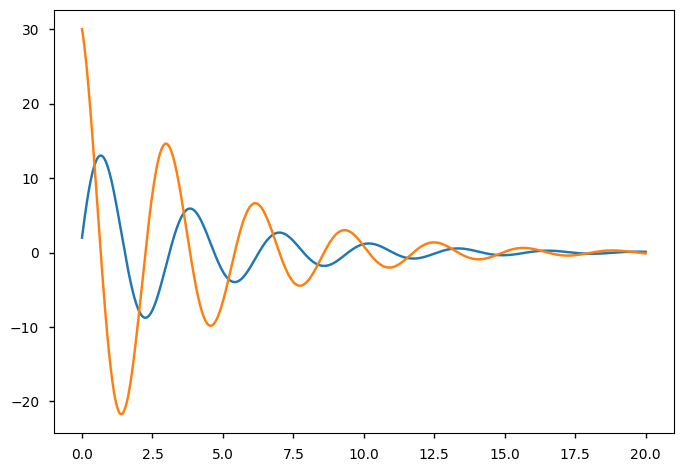

In [423]:
tpoints, custom, d_custom = rk4(damped_spring, 2, 30, 1000, [0,20], 4, 16, 2)

methods.append(custom) # Add the solution to the methods list

plt.plot(tpoints,custom) # Visualize the result
plt.plot(tpoints,d_custom)
plt.show()

2. Now we can simplify the process of solving this system by using an optimized solving library <code>scipy.integrate.odeint</code>. It will require use to modify our spring function, but the modification is simple. In essence, we combine $x$ and $v$ into one array variable which will be unpacked in the function, and we add the grid point $t$ so that the solver will work with our function.

In [424]:
def damped_oscillator(u, t, m, k, c):
    """
    Define a function that accepts the guess for x(t) and dx(t)/dt => v(t) inside an array u

    Args:
        u (array): Array containing the guess for x(t), v(t)
        t (float): Time grid point
        m (float): Mass of object
        k (float): Spring constant
        c (float): Damping constant

    Returns:
        array: An array containing the value of the velocity and acceleration of the system
    """    
    x, v = u # Unpack the variables
    return np.array([v, -(c/m)*v-(k/m)*x]) # Return a system of equations

With our modified function we can plug it into <code>odeint</code> with a list of initial guesses for the position and velocity along with a time grid and finally the arguments for the mass, spring constant, and damping coefficient to get a solution for each equation.

In [425]:
tgrid = np.linspace(0,20,1000) # Grid
solution = odeint(damped_oscillator, [2,30], tgrid, args=(4,16,2))

scipy, d_scipy = solution[:,0], solution[:,1] # Unpack solutions for x(t), v(t)

And we visualize the result after adding it to the list of successful methods

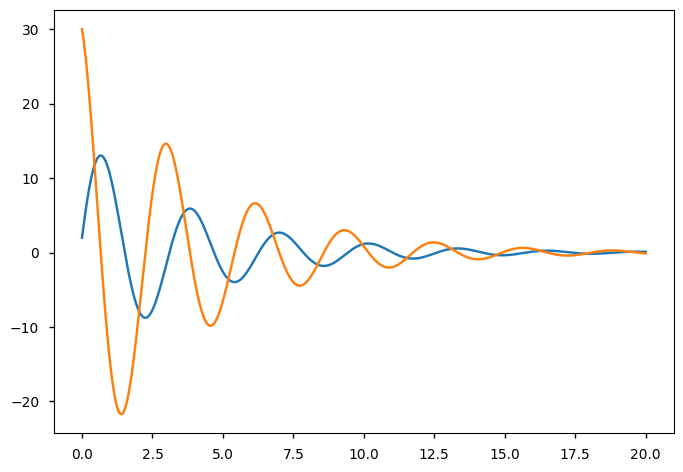

In [426]:
methods.append(scipy) # Add the solution array to a list of successful methods

plt.plot(tgrid, scipy) # Visualize the result
plt.plot(tgrid, d_scipy)
plt.show()

3. Lastly, we can use <code>sympy</code> to analytically solve the ODE before plotting and converting into a <code>numpy</code>-friendly function. The first step is defining our constants and variables

In [427]:
m, k, c = sym.symbols('m k c', real = True) # Physical constants
t = sym.Symbol('t', real=True, positive=True) # Independent variable where time is strictly real and positive
x = sym.Function('x')(t) # The dependent variable in the system

Next, we build the equation to solve by substituting in the constants and building the left and right hand side of the equation

In [428]:
LHS, RHS = m*sym.diff(sym.diff(x, t), t), -k*x-c*sym.diff(x, t)
system = sym.Eq(0, RHS-LHS).subs({m:4,k:16,c:2})
system # Show the resulting equation

Eq(0, -16*x(t) - 2*Derivative(x(t), t) - 4*Derivative(x(t), (t, 2)))

To obtain the solution, we define the initial conditions as a dictionary of values corresponding to the position and velocity. We then plug this into the <code>dsolve</code> function from <code>sympy</code> and single-out only the right hand side of the output equation

In [429]:
initial = {x.subs(t,0):2,
           sym.diff(x,t).subs(t,0):30} 
# Initial conditions

solution = sym.dsolve(system, ics=initial).rhs # Solve the system
solution # Display the analytic solution

(122*sqrt(7)*sin(3*sqrt(7)*t/4)/21 + 2*cos(3*sqrt(7)*t/4))*exp(-t/4)

We plot this in 3D but ultimately this is a one dimensional system

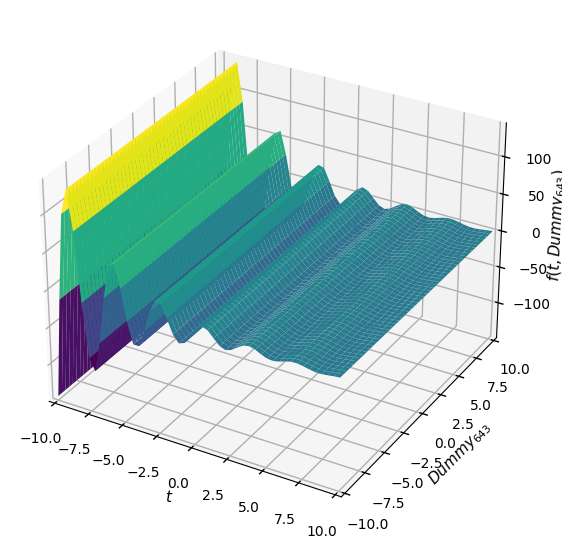

In [430]:
plot3d(solution) # Visualize the result

Lastly, we need to convert the solution into a form that can accept different grids as <code>numpy</code> arrays. This is done using <code>lambdify</code>. We identify the independent variable $t$, and the function that it corresponds to (the analytic solution), and output a function that accepts arrays.

In [431]:
t_array = np.linspace(0,20,1000) # Define the grid
solution_numpy = sym.lambdify((t), solution) # Convert the expression
sympy = solution_numpy(t_array) # Run the expression with the grid

As previous, we visualize the method and save the result

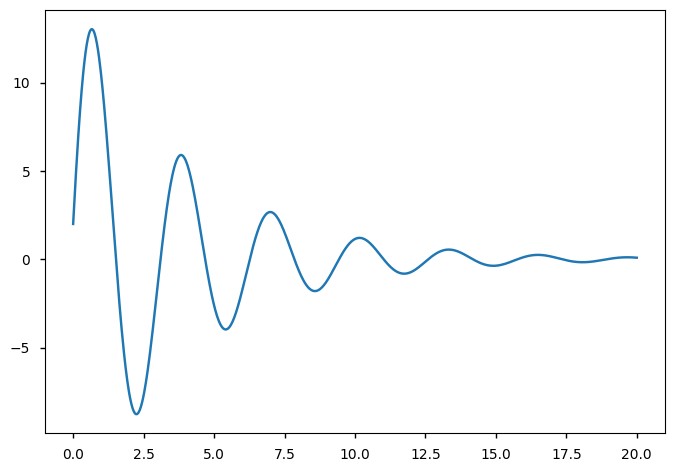

In [432]:
plt.plot(t_array, sympy) # Visualize the result
methods.append(sympy) # Add to the list of successful methods

4. We have collected the different methods into a list, so we simply iterate over this list and plot the results. The thickness of each result is different to allow them to be seen while overlapping.

Text(0.5, 1.0, 'Comparison of Methods')

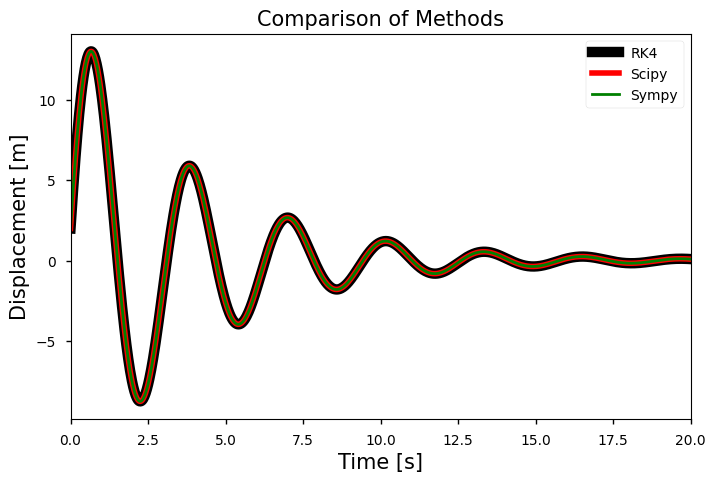

In [433]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))

linewidths = [7.5, 4, 2]
colors = ['k', 'r', 'g']
labels = ['RK4', 'Scipy', 'Sympy']
for idx, graph in enumerate(methods):
    ax.plot(t_array, graph, linewidth = linewidths[idx], color=colors[idx], label=labels[idx])
ax.legend(loc='best')    
ax.set_xlim([t_array[0], t_array[-1]])

ax.set_xlabel('Time [s]', fontsize=15)
ax.set_ylabel('Displacement [m]', fontsize=15)
ax.set_title('Comparison of Methods', fontsize=15)

As you can see, all three methods are in good agreement. This means that we have correctly implemented our RK4 algorithm to solve the system of equations!